<a href="https://colab.research.google.com/github/KaifAhmad1/code-test/blob/main/PileGemma_for_Visual_Question_Answering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Fine Tuning PileGemma for Visual Question Answering on Pathology Dataset:**

In [1]:
!pip uninstall -y torch torchvision
!pip install torch==2.3.0 torchvision==0.15.0
!pip install -qU xformers trl peft accelerate bitsandbytes
!pip install -q git+https://github.com/huggingface/transformers
!pip install -q datasets pillow

Found existing installation: torch 2.3.0
Uninstalling torch-2.3.0:
  Successfully uninstalled torch-2.3.0
  Using cached torch-2.3.0-cp310-cp310-manylinux1_x86_64.whl (779.1 MB)
  Using cached torchvision-0.15.0-cp310-cp310-manylinux1_x86_64.whl (6.0 MB)
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install torch==2.3.0 and torchvision==0.15.0 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested torch==2.3.0
    torchvision 0.15.0 depends on torch==2.0.0+cu117

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip attempt to solve the dependency conflict

ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts
ERROR: pip's dependency resolver does not currently

In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
from datasets import load_dataset
train_dataset = load_dataset("flaviagiammarino/path-vqa",split="train")
test_dataset = load_dataset("flaviagiammarino/path-vqa",split="test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
train_dataset[5]
print(train_dataset[5])

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=792x528 at 0x7B8A6AF2C880>, 'question': 'is normal palmar creases present?', 'answer': 'no'}


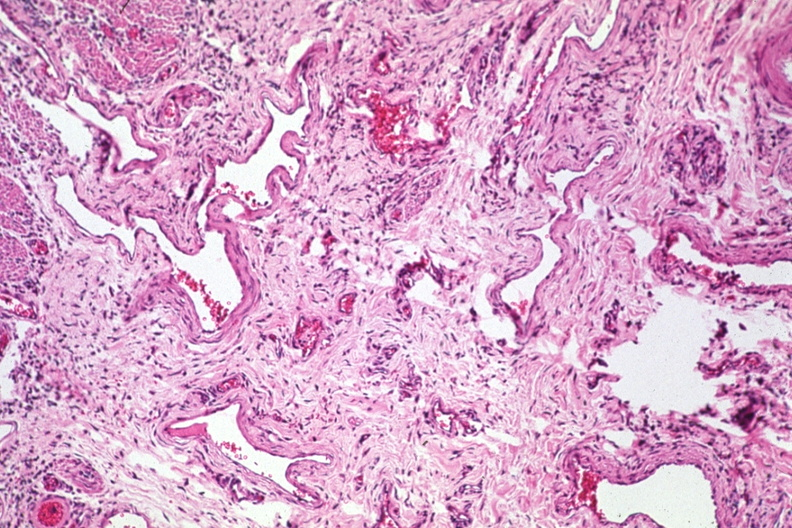

In [5]:
train_dataset[5]['image']

In [6]:
train_dataset

Dataset({
    features: ['image', 'question', 'answer'],
    num_rows: 19654
})

In [7]:
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from trl import SFTTrainer
from transformers import (
    PaliGemmaForConditionalGeneration,
    PaliGemmaProcessor,
    TrainingArguments,
    BitsAndBytesConfig,
    pipeline,
    logging
)
from datasets import Dataset

In [8]:
model_name = 'google/paligemma-3b-mix-224'

In [9]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

In [10]:
model = PaliGemmaForConditionalGeneration.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    low_cpu_mem_usage=True
)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
processor = PaliGemmaProcessor.from_pretrained(
    model_name
 )

In [12]:
class VQADataset(Dataset):
    def __init__(self, images, captions, tokenizer, max_length=20):
        self.images = images
        self.captions = captions
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        image = self.images[idx]
        caption = self.captions[idx]

        encoding = self.tokenizer(caption, truncation=True, padding='max_length', max_length=self.max_length)
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']

        # Assuming `image` is preprocessed and ready for input
        pixel_values = torch.tensor(image).float()

        return {
            "pixel_values": pixel_values,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": torch.tensor([0])  # Dummy label for simplicity
        }

In [13]:
import torch
from torch.utils.data import Dataset

class VQADataset(Dataset):
    def __init__(self, images, questions, answers, processor):
        self.images = images
        self.questions = questions
        self.answers = answers
        self.processor = processor

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        image = self.images[idx]
        question = self.questions[idx]
        answer = self.answers[idx]

        encoding = self.processor(
            text=question,
            images=image,
            return_tensors="pt",
            padding=True,
            truncation=True
        )
        encoding["labels"] = self.processor.tokenizer(answer, return_tensors="pt", padding=True, truncation=True).input_ids

        return encoding

In [ ]:
train_images = [item['image'] for item in train_dataset]
train_questions = [item['question'] for item in train_dataset]
train_answers = [item['answer'] for item in train_dataset]

test_images = [item['image'] for item in test_dataset]
test_questions = [item['question'] for item in test_dataset]
test_answers = [item['answer'] for item in test_dataset]

train_vqa_dataset = VQADataset(train_images, train_questions, train_answers, processor)
test_vqa_dataset = VQADataset(test_images, test_questions, test_answers, processor)